In [1]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
datapath = "data/pvpcdata.csv"
day = 24

In [4]:
df = pd.read_csv(datapath, sep = ";")

In [5]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [6]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [7]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [8]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [9]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

In [10]:
# df = df.loc[df.date >= '2021-01-01 00:00:00']

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

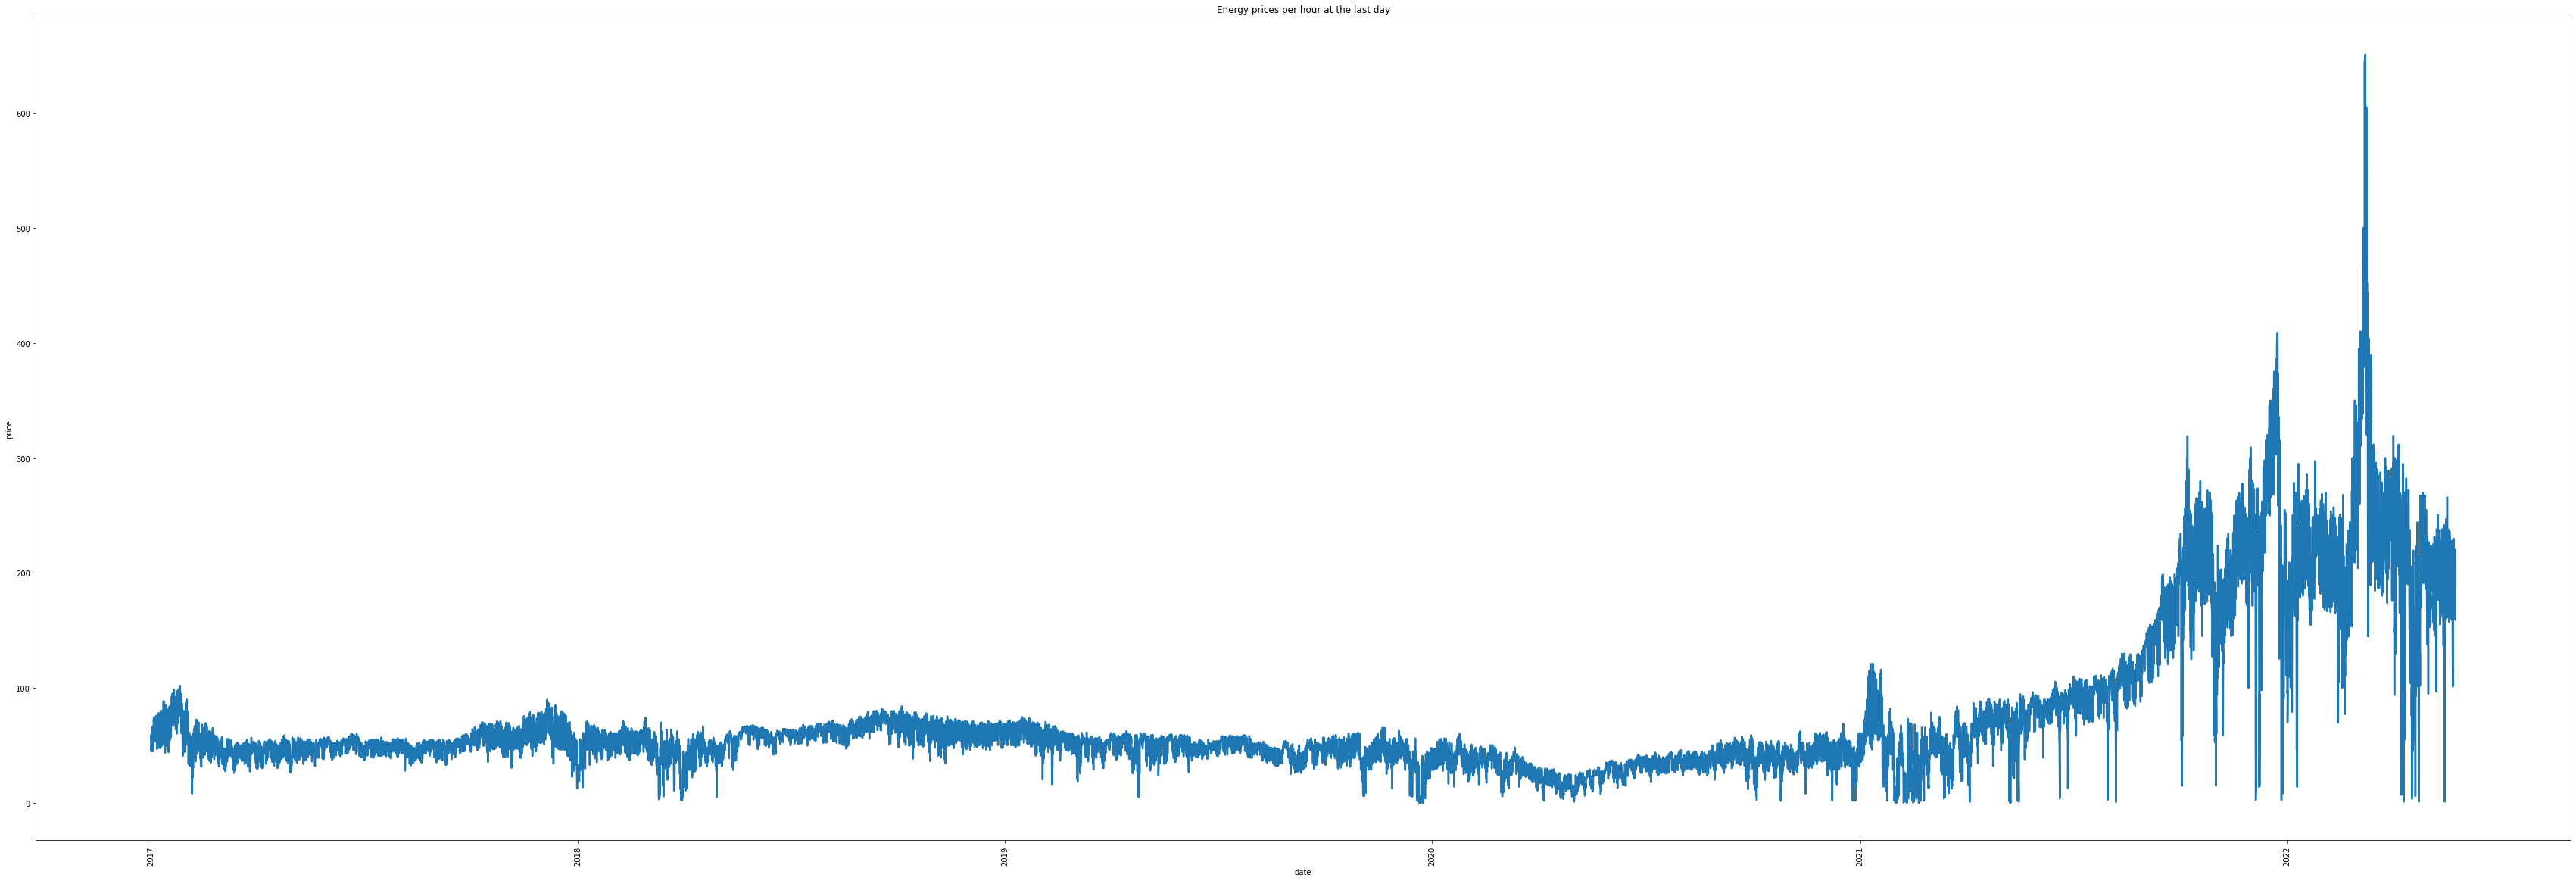

In [11]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90)
sns.lineplot(x = 'date', y = 'price', data = df, linewidth = 2.5, ax = ax).set(title='Energy prices per hour at the last day')

In [12]:
df = df[['date', 'price']]

In [13]:
date = df.pop('date')

In [14]:
timestamp = date.map(datetime.datetime.timestamp)

In [15]:
sec_day = 24*60*60
sec_week = 7 * day
sec_year = 365.2425 * day

df['day_sin'] = np.sin(timestamp * (2*np.pi / sec_day))
df['day_cos'] = np.cos(timestamp * (2*np.pi / sec_day))
df['week_sin'] = np.sin(timestamp * (2*np.pi / sec_week))
df['week_cos'] = np.cos(timestamp * (2*np.pi / sec_week))
df['year_sin'] = np.sin(timestamp * (2*np.pi / sec_year))
df['year_cos'] = np.cos(timestamp * (2*np.pi / sec_year))

#Tamaño de ventana de 1 dia
w_size = 24 * 3
#Número de entradas
n_inputs = len(df.columns)
n_outputs = 24 

In [16]:
# Método de la ventana, parámetro único en X
# Aquí podemos ver como dadas 5 horas, predice la siguiente
# [[P1, DS1, DC1, YS1, YC1],[P2...],[P3...],[P4...],[P5...] --> [P6]
# [P2,P3,P4,P5,P6] --> [P7]

def df_to_x_y_multiple_input_output(df, w_size, n_outputs):
    df_as_np = df.to_numpy()
    x = []
    y = []
    
    #Bucle para construir la ventana varia. Incrementa según el número de salidas
    for i in range(0, len(df_as_np) - w_size - n_outputs, n_outputs):
        row = [r for r in df_as_np[i:(i + w_size)]]
        x.append(row)
        
        #Solo queremos el precio
        label = []
        for j in range((i + w_size), (i + w_size + n_outputs)):
            label.append(df_as_np[j][0])
        
        y.append(label)
    
    return np.array(x), np.array(y)

In [17]:
x, y = df_to_x_y_multiple_input_output(df, w_size, n_outputs)
x.shape, y.shape

((1967, 72, 7), (1967, 24))

In [18]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((1376, 72, 7), (1376, 24), (395, 72, 7), (395, 24), (196, 72, 7), (196, 24))

In [20]:
x_mean = np.mean(x[:, :, 0])
x_std = np.std(x[:, :, 0])

In [21]:
def standarize_input(df):
    df[:, :, 0] = (df[:, :, 0] - x_mean) / x_std
    return df

def standarize_output(df):
    df[:,:] = (df[:,:] - x_mean) / x_std
    return df

In [22]:
x_train_norm = standarize_input(x_train)
x_test_norm = standarize_input(x_test)
x_val_norm = standarize_input(x_val)
y_train_norm = standarize_output(y_train)
y_test_norm = standarize_output(y_test)
y_val_norm = standarize_output(y_val)

In [23]:
print(y_train_norm)

[[-0.14961399 -0.25810557 -0.28975574 ... -0.04112242 -0.11225374
  -0.16168674]
 [-0.14292504 -0.14292504 -0.29008203 ... -0.00294644 -0.08321389
  -0.04340646]
 [-0.20035216 -0.29171348 -0.32222164 ...  0.05284922  0.03278236
  -0.0027833 ]
 ...
 [-0.58178568 -0.58096996 -0.56351342 ... -0.45339039 -0.50070251
  -0.50657574]
 [-0.50070251 -0.48944549 -0.45469556 ... -0.47280468 -0.50135509
  -0.51163324]
 [-0.51701703 -0.51701703 -0.45339039 ... -0.64573861 -0.65585361
  -0.69598734]]


In [24]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(128))
    model.add(tf.keras.layers.Dense(64, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [25]:
def build_model_lstm_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(138, return_sequences = True))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(32, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [26]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [27]:
def build_model_cnn_relu():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2, activation = 'relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [28]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [29]:
def build_model_gru_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64, return_sequences = True))
    model.add(tf.keras.layers.GRU(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [30]:
model_lstm = build_model_lstm()
model_lstm_ret_seq = build_model_lstm_ret_seq()
model_cnn = build_model_cnn()
model_cnn_relu = build_model_cnn_relu()

2022-06-08 20:29:04.944167: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 20:29:05.996054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18210 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-08 20:29:05.997220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 25800 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [32]:
history_lstm = model_lstm.fit(
    x_train_norm,
    y_train,
    validation_data = (x_val_norm, y_val),
    epochs = 500,
    verbose = 1,
    shuffle = False, 
    callbacks = callback
)

Epoch 1/500


2022-06-08 20:29:07.904881: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


43/43 [==============================] - 3s 23ms/step - loss: 0.0661 - mae: 0.2061 - mse: 0.0661 - val_loss: 6.7807 - val_mae: 2.3703 - val_mse: 6.7807
Epoch 2/500
43/43 [==============================] - 1s 14ms/step - loss: 0.0263 - mae: 0.1276 - mse: 0.0263 - val_loss: 6.7095 - val_mae: 2.3525 - val_mse: 6.7095
Epoch 3/500
43/43 [==============================] - 1s 14ms/step - loss: 0.0276 - mae: 0.1313 - mse: 0.0276 - val_loss: 6.4568 - val_mae: 2.2957 - val_mse: 6.4568
Epoch 4/500
43/43 [==============================] - 1s 14ms/step - loss: 0.0229 - mae: 0.1182 - mse: 0.0229 - val_loss: 5.9757 - val_mae: 2.1813 - val_mse: 5.9757
Epoch 5/500
43/43 [==============================] - 1s 14ms/step - loss: 0.0146 - mae: 0.0929 - mse: 0.0146 - val_loss: 6.5503 - val_mae: 2.3201 - val_mse: 6.5503
Epoch 6/500
43/43 [==============================] - 1s 14ms/step - loss: 0.0144 - mae: 0.0918 - mse: 0.0144 - val_loss: 6.2498 - val_mae: 2.2542 - val_mse: 6.2498
Epoch 7/500
43/43 [=========

In [33]:
history_cnn = model_cnn.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False, 
    callbacks = callback
)

Epoch 1/500
43/43 [==============================] - 1s 8ms/step - loss: 0.1507 - mae: 0.3051 - mse: 0.1507 - val_loss: 7.3862 - val_mae: 2.3203 - val_mse: 7.3862
Epoch 2/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0662 - mae: 0.1901 - mse: 0.0662 - val_loss: 7.5832 - val_mae: 2.3373 - val_mse: 7.5832
Epoch 3/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0378 - mae: 0.1438 - mse: 0.0378 - val_loss: 7.5946 - val_mae: 2.3369 - val_mse: 7.5946
Epoch 4/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0329 - mae: 0.1373 - mse: 0.0329 - val_loss: 7.6069 - val_mae: 2.3379 - val_mse: 7.6069
Epoch 5/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0264 - mae: 0.1237 - mse: 0.0264 - val_loss: 7.6273 - val_mae: 2.3381 - val_mse: 7.6273
Epoch 6/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0245 - mae: 0.1190 - mse: 0.0245 - val_loss: 7.6582 - val_mae: 2.3362 - val_mse: 7.6582
Epoch 7/500
43/43 [===

In [34]:
history_cnn_relu = model_cnn_relu.fit(
    x_train_norm,
    y_train,
    validation_data = (x_val_norm, y_val),
    epochs = 500,
    verbose = 1,
    shuffle = False, 
    callbacks = callback
)

Epoch 1/500
43/43 [==============================] - 1s 8ms/step - loss: 0.1348 - mae: 0.2867 - mse: 0.1348 - val_loss: 7.7534 - val_mae: 2.5403 - val_mse: 7.7534
Epoch 2/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0863 - mae: 0.2207 - mse: 0.0863 - val_loss: 7.0904 - val_mae: 2.4261 - val_mse: 7.0904
Epoch 3/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0553 - mae: 0.1740 - mse: 0.0553 - val_loss: 7.1212 - val_mae: 2.4294 - val_mse: 7.1212
Epoch 4/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0370 - mae: 0.1409 - mse: 0.0370 - val_loss: 7.1389 - val_mae: 2.4312 - val_mse: 7.1389
Epoch 5/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0297 - mae: 0.1291 - mse: 0.0297 - val_loss: 7.1437 - val_mae: 2.4299 - val_mse: 7.1437
Epoch 6/500
43/43 [==============================] - 0s 6ms/step - loss: 0.0240 - mae: 0.1163 - mse: 0.0240 - val_loss: 7.1465 - val_mae: 2.4290 - val_mse: 7.1465
Epoch 7/500
43/43 [===

In [35]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

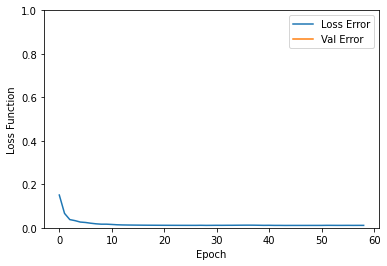

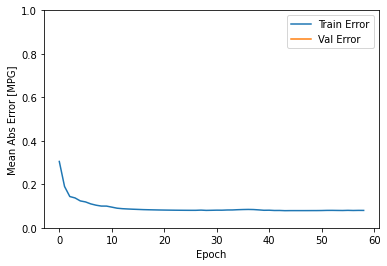

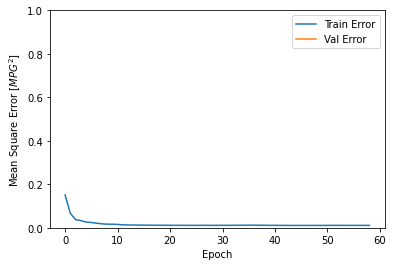

In [36]:
plot_history(history_cnn, 0, 1, 1, 1)

In [37]:
y_pred_lstm = model_lstm.predict(x_test_norm)
y_pred_cnn_relu = model_cnn_relu.predict(x_test_norm)

In [38]:
y_pred_cnn = model_cnn.predict(x_test_norm)

In [39]:
def inverse_standarize_input(arr):
    arr = (arr * x_std) + x_mean
    return arr

In [40]:
y_pred_cnn = inverse_standarize_input(y_pred_cnn)
y_test = inverse_standarize_input(y_test_norm)

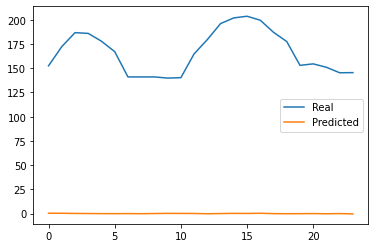

In [41]:
plt.plot(y_test[y_test.shape[0] - 1], label='Real')
plt.plot(y_pred_lstm[y_test.shape[0] - 1], label='Predicted')
plt.legend()

In [42]:
print(y_pred_cnn)

[[  33.20337    30.923267   31.290714 ...   37.105232   36.50606
    33.586452]
 [  29.71592    27.753159   28.18655  ...   33.370636   32.863285
    29.834133]
 [  30.672382   29.125664   29.454193 ...   34.68723    33.88406
    30.882416]
 ...
 [ -86.7387    108.39758    14.516022 ...   26.893158  200.77118
  -103.938255]
 [ -80.93612   104.58294    18.671574 ...   40.181053  187.1683
   -94.97344 ]
 [ -63.009163   99.66846    22.195381 ...   48.84346   172.9944
   -66.50373 ]]


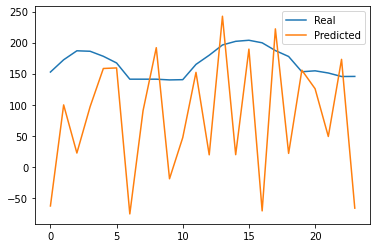

In [43]:
plt.plot(y_test[y_test.shape[0] - 1], label='Real')
plt.plot(y_pred_cnn[y_test.shape[0] - 1], label='Predicted')
plt.legend()

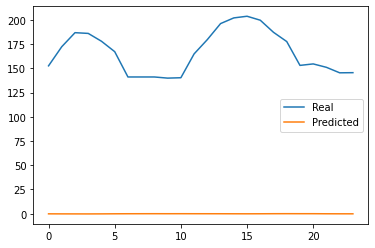

In [44]:
plt.plot(y_test[y_test.shape[0] - 1], label='Real')
plt.plot(y_pred_cnn_relu[y_test.shape[0] - 1], label='Predicted')
plt.legend()

In [45]:
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)

In [46]:
print(rmse_cnn)

71.4211084456851


In [47]:
print(mae_cnn)

35.12521976044409
